In [1]:
# Importing Required Libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Specify the path to your dataset directory
dataset_path = '/kaggle/input/new-wc-dataset/Dataset_Weed_Crop'

# Defining constants
image_size = (299, 299)  # Xception expects input size (299, 299)
num_classes = 2  # Crop and Weed

# Creating empty lists to store data
data = []
labels = []

# Loading and preprocessing the dataset
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    class_label = 0 if class_name == 'Crop' else 1  # Assign labels (0 for Crop, 1 for Weed)
    for image_filename in os.listdir(class_path):
        image_path = os.path.join(class_path, image_filename)
        image = load_img(image_path, target_size=image_size)
        image = img_to_array(image)
        image = image / 255.0  # Rescale pixel values to [0, 1]
        data.append(image)
        labels.append(class_label)

# Converting data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

In [3]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# To Print the shapes to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (4200, 299, 299, 3), y_train shape: (4200, 2)
X_val shape: (900, 299, 299, 3), y_val shape: (900, 2)
X_test shape: (900, 299, 299, 3), y_test shape: (900, 2)


In [4]:
# Data Augmentation
# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,  # You can adjust the rotation range as needed
    width_shift_range=0.2,  # You can adjust the shift range as needed
    height_shift_range=0.2,
    fill_mode='nearest'  # Filling mode for pixels outside the boundaries
)

# Fit the generator on the training data
train_datagen.fit(X_train)

# Create data generators for training and validation
batch_size = 32  # You can adjust the batch size as needed
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = ImageDataGenerator(rescale=1./255).flow(X_val, y_val, batch_size=batch_size)


In [5]:
# Define class weights to handle imbalance
class_labels = np.unique(labels)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=labels)
class_weight_dict = dict(zip(class_labels, class_weights))

# Step 5: Model Selection - Xception
def create_xception_model(input_shape=(299, 299, 3), num_classes=2):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    return model

# Create the Xception model
model = create_xception_model(input_shape=(299, 299, 3), num_classes=num_classes)


83683744/83683744 [==============================] - 0s 0us/step


In [6]:
# Compile the model with class weights
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 22961706 (87.59 MB)
Trainable params: 2100226 (8.01 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [7]:
# Define hyperparameters for training
epochs = 50  # You can adjust the number of epochs as needed
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    class_weight=class_weight_dict,  # Use class weights
    use_multiprocessing=False,
    callbacks=[early_stopping]  # Add the EarlyStopping callback
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

Epoch 1/50
132/132 [==============================] - 102s 671ms/step - loss: 0.1971 - accuracy: 0.9267 - val_loss: 0.1298 - val_accuracy: 0.9489
Epoch 2/50
132/132 [==============================] - 93s 703ms/step - loss: 0.1116 - accuracy: 0.9600 - val_loss: 0.1066 - val_accuracy: 0.9578
Epoch 3/50
132/132 [==============================] - 95s 719ms/step - loss: 0.0923 - accuracy: 0.9655 - val_loss: 0.1260 - val_accuracy: 0.9478
Epoch 4/50
132/132 [==============================] - 95s 720ms/step - loss: 0.0604 - accuracy: 0.9814 - val_loss: 0.0406 - val_accuracy: 0.9867
Epoch 5/50
132/132 [==============================] - 93s 703ms/step - loss: 0.0461 - accuracy: 0.9852 - val_loss: 0.0584 - val_accuracy: 0.9844
Epoch 6/50
132/132 [==============================] - 93s 706ms/step - loss: 0.0361 - accuracy: 0.9895 - val_loss: 0.0251 - val_accuracy: 0.9911
Epoch 7/50
132/132 [==============================] - 92s 698ms/step - loss: 0.0539 - accuracy: 0.9812 - val_loss: 0.0394 - val_a

In [8]:
# Create a data generator for the test set
test_generator = ImageDataGenerator(rescale=1./255).flow(X_test, y_test, batch_size=1, shuffle=False)

# Get predictions from the model
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the classification report
report = classification_report(y_true, y_pred_classes, target_names=['Crop', 'Weed'])
print(report)

900/900 [==============================] - 10s 10ms/step
              precision    recall  f1-score   support

        Crop       1.00      0.99      0.99       440
        Weed       0.99      1.00      0.99       460

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



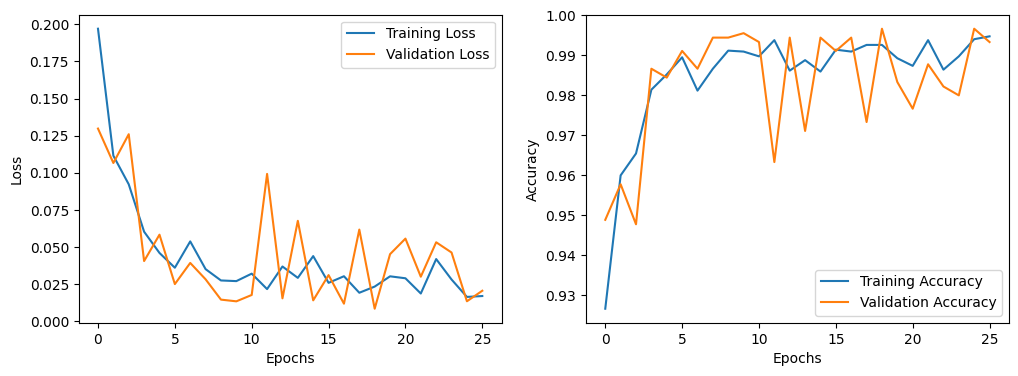

In [9]:
#Visualize Training and Validation Curves
# Extract training history from the history object
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

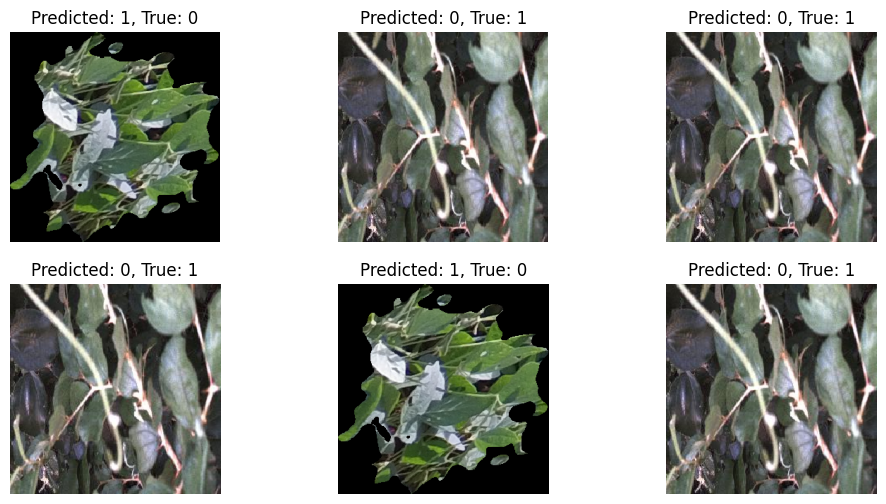

In [10]:
#Analyze Misclassified Images
import random

misclassified_images = []

for i in range(len(y_true)):
    if y_pred_classes[i] != y_true[i]:
        misclassified_images.append((X_test[i], y_pred_classes[i], y_true[i]))

# Randomly select and display some misclassified images
plt.figure(figsize=(12, 6))
num_displayed = min(6, len(misclassified_images))
for i in range(num_displayed):
    index = random.randint(0, len(misclassified_images) - 1)
    image, predicted_class, true_class = misclassified_images[index]
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}, True: {true_class}')
    plt.axis('off')

plt.show()


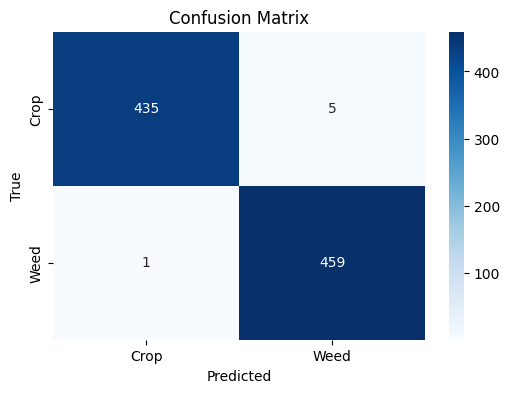

In [11]:
# Compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
labels = ['Crop', 'Weed']
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()